In [10]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import shap
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Lasso, Ridge, RANSACRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt

import joblib
import os

# Regression on Response Time

In [11]:
# Load data

file_path = os.path.join("data","processed_data.csv")

df = pd.read_csv(file_path)  

print(len(df))
df.head()

364


,Response Time,Availability,Throughput,Successability,Reliability,Compliance,Best Practices,Latency,Documentation,WsRF,Class,Service Name_0,Service Name_1,Service Name_2,Service Name_3
0,45.00,83.0,5.6,50,97.4,89,91.0,43.00,58,100.0,1,0,0,0,0
1,71.75,100.0,14.6,88,85.5,78,80.0,64.42,86,93.0,1,0,0,0,0
2,117.00,100.0,23.4,83,88.0,100,87.0,111.00,59,90.0,1,0,0,0,0
3,70.00,100.0,5.4,83,79.3,100,75.0,63.00,91,90.0,1,0,0,0,0
4,105.20,100.0,18.2,80,92.2,78,84.0,104.60,91,90.0,1,0,0,0,0


In [12]:
X_baseline=df.drop(columns=['Response Time', 'Latency', 'Service Name_0', 'Service Name_1', 'Service Name_2', 'Service Name_3', 'Compliance', 'Class', 'WsRF'])
Y_baseline=df['Response Time']

# Baseline

In [13]:
baseline_reg=LinearRegression()

X_rest, X_test, y_rest, y_test = train_test_split(
    X_baseline, Y_baseline, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_rest, y_rest, test_size=0.53, random_state=42
)


k_folds = KFold(n_splits=5)

scores = cross_val_score(baseline_reg, X_rest, y_rest, cv=k_folds, scoring='r2')
print(scores)
print(f"{baseline_reg}: CV R² mean={scores.mean():.4f}")

[ 0.02835219 -0.33099366  0.17048235  0.06691947  0.05912458]
LinearRegression(): CV R² mean=-0.0012


- feature importance 

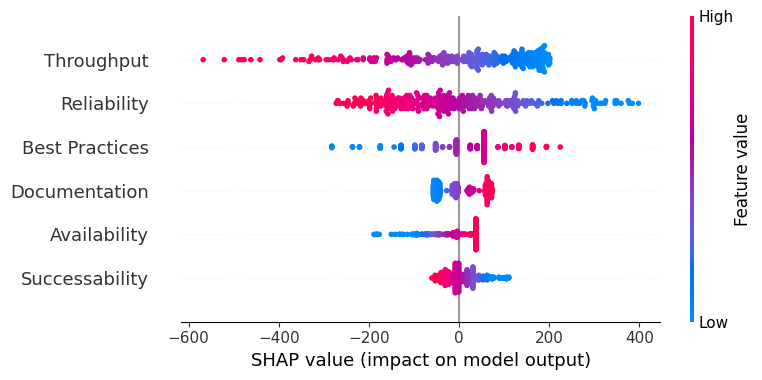

In [35]:
baseline_reg.fit(X_rest,y_rest)
explainer = shap.Explainer(baseline_reg.predict, X_rest)  
shap_values = explainer(X_rest)

shap.summary_plot(shap_values, X_rest)

[0.00593735 0.10028515 0.00641024 0.09174616 0.03741368 0.00758731]


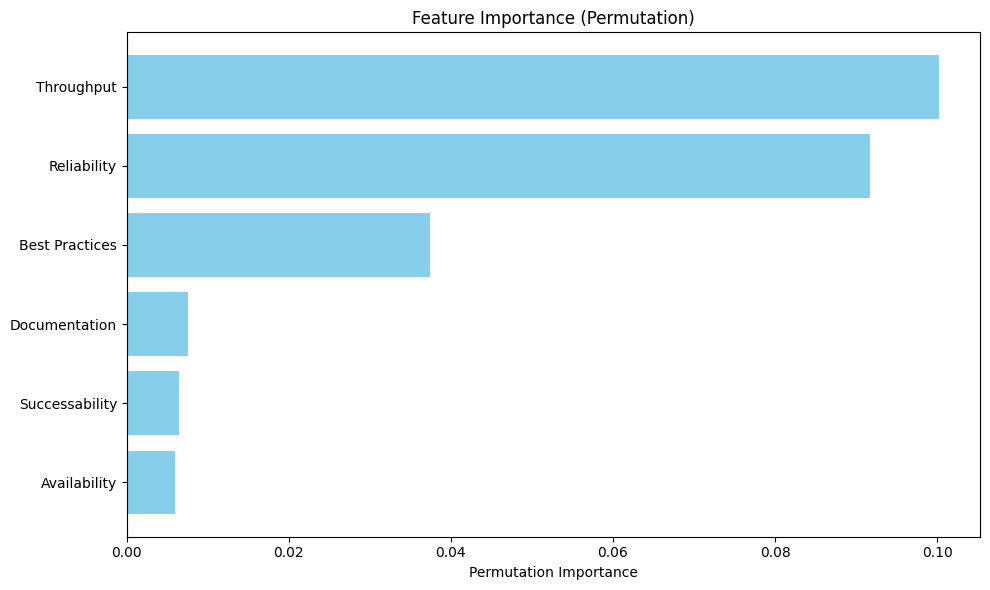

In [15]:
#baseline_reg.fit(X_rest, y_rest)
result = permutation_importance(baseline_reg, X_rest, y_rest, n_repeats=10, random_state=42)
print(result.importances_mean)


# Feature names and importance values
importances = result.importances_mean
features = X_rest.columns

# Create DataFrame for sorting
df = pd.DataFrame({'Feature': features, 'Importance': importances})
df_sorted = df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_sorted['Feature'], df_sorted['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Feature Importance (Permutation)')
plt.gca().invert_yaxis()  # Highest importance at top
plt.axvline(0, color='gray', linewidth=0.8)
plt.tight_layout()
plt.show()

With feature importance (SHAP) Service Name, compliance, and class (and so WsRF) variables must be removed as could likely cause leakage and bias

# RandomizedSearch CV

In [ ]:

param_distributions = {
    'ridge': {
        'model__alpha': np.logspace(-3, 1, 10)
    },
    'lasso': {
        'model__alpha': np.logspace(-3, 1, 10)
    },
    'ransac': {
        'min_samples': [0.5, 0.75, 0.9],
        'residual_threshold': [1.0, 2.0, 5.0]
    },
    'rf_reg': {
        'n_estimators': np.arange(50, 300, 50),
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'svr': {
        'model__C': np.logspace(-2, 2, 5),
        'model__epsilon': [0.01, 0.1, 0.5, 1],
        'model__kernel': ['linear', 'rbf']
    },
    'poly_reg': {
        'poly_features__degree': [2, 3, 4]
    }
}

Tried with both MinMax and Standard scalers but no imporvements seem significant

In [25]:
reg_scores = {}
best_models = {}

scalers = [StandardScaler(), MinMaxScaler()]

for scaler in scalers:
    print(scaler)
    regressors = {
        'ridge': Pipeline([
            ('scaler', scaler),
            ('model', Ridge())
        ]),
        'lasso': Pipeline([
            ('scaler', scaler),
            ('model', Lasso())
        ]),
        'ransac': RANSACRegressor(random_state=42),
        'tree_reg': DecisionTreeRegressor(),
        'rf_reg': RandomForestRegressor(random_state=42),
        'svr': Pipeline([
            ('scaler', scaler),
            ('model', SVR())
        ]),
        'poly_reg': Pipeline([
            ('scaler', scaler),
            ('poly_features', PolynomialFeatures(include_bias=False)),
            ('model', LinearRegression())
        ])
    }


    k_folds = KFold(n_splits=5)

    # Loop through regressors
    for name, reg in regressors.items():
        if name in param_distributions:
            # Apply RandomizedSearchCV for models with hyperparameters
            search = RandomizedSearchCV(
                reg,
                param_distributions=param_distributions[name],
                n_iter=10,
                scoring='r2',
                cv=k_folds,
                n_jobs=-1,
                random_state=42
            )
            search.fit(X_rest, y_rest)
            best_models[name] = search.best_estimator_
            reg_scores[name] = search.best_score_
            print(f"{name}: Best CV R²={search.best_score_:.4f}, Params={search.best_params_}")
        else:
            # Simple cross-validation for models without tuning
            scores = cross_val_score(reg, X_rest, y_rest, cv=k_folds, scoring='r2')
            reg_scores[name] = scores.mean()
            reg.fit(X_rest, y_rest)
            best_models[name] = reg
            print(f"{name}: CV R² mean={scores.mean():.4f}")
    print('= = =')


StandardScaler()
ridge: Best CV R²=0.0066, Params={'model__alpha': np.float64(10.0)}
lasso: Best CV R²=0.0106, Params={'model__alpha': np.float64(10.0)}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ransac: Best CV R²=0.0551, Params={'residual_threshold': 5.0, 'min_samples': 0.9}
tree_reg: CV R² mean=-3.7652
rf_reg: Best CV R²=0.1093, Params={'n_estimators': np.int64(200), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
svr: Best CV R²=0.0001, Params={'model__kernel': 'rbf', 'model__epsilon': 1, 'model__C': np.float64(100.0)}
poly_reg: Best CV R²=-0.2064, Params={'poly_features__degree': 2}
= = =
MinMaxScaler()


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ridge: Best CV R²=0.0312, Params={'model__alpha': np.float64(10.0)}
lasso: Best CV R²=0.0251, Params={'model__alpha': np.float64(10.0)}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


ransac: Best CV R²=0.0551, Params={'residual_threshold': 5.0, 'min_samples': 0.9}
tree_reg: CV R² mean=-3.3944
rf_reg: Best CV R²=0.1093, Params={'n_estimators': np.int64(200), 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5}
svr: Best CV R²=-0.0036, Params={'model__kernel': 'rbf', 'model__epsilon': 0.5, 'model__C': np.float64(100.0)}


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


poly_reg: Best CV R²=-0.2064, Params={'poly_features__degree': 2}
= = =


In [34]:
import pandas as pd

results = []

scalers = [StandardScaler(), MinMaxScaler()]

for scaler in scalers:
    scaler_name = scaler.__class__.__name__
    regressors = {
        'ridge': Pipeline([('scaler', scaler), ('model', Ridge())]),
        'lasso': Pipeline([('scaler', scaler), ('model', Lasso())]),
        'ransac': RANSACRegressor(random_state=42),
        'tree_reg': DecisionTreeRegressor(),
        'rf_reg': RandomForestRegressor(random_state=42),
        'svr': Pipeline([('scaler', scaler), ('model', SVR())]),
        'poly_reg': Pipeline([('scaler', scaler), ('poly_features', PolynomialFeatures(include_bias=False)), ('model', LinearRegression())])
    }

    k_folds = KFold(n_splits=5)

    for name, reg in regressors.items():
        if name in param_distributions:
            search = RandomizedSearchCV(
                reg,
                param_distributions=param_distributions[name],
                n_iter=10,
                scoring='r2',
                cv=k_folds,
                n_jobs=-1,
                random_state=42
            )
            search.fit(X_rest, y_rest)
            best_models[name] = search.best_estimator_
            reg_scores[name] = search.best_score_

            results.append({
                'Scaler': scaler_name,
                'Model': name,
                'Best_R2': search.best_score_,
                'Params': search.best_params_
            })
        else:
            scores = cross_val_score(reg, X_rest, y_rest, cv=k_folds, scoring='r2')
            reg.fit(X_rest, y_rest)
            best_models[name] = reg
            reg_scores[name] = scores.mean()

            results.append({
                'Scaler': scaler_name,
                'Model': name,
                'Best_R2': scores.mean(),
                'Params': None
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)

print(results_df)


c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


            Scaler     Model   Best_R2  \
0   StandardScaler     ridge  0.006577   
1   StandardScaler     lasso  0.010573   
2   StandardScaler    ransac  0.055112   
3   StandardScaler  tree_reg -3.019785   
4   StandardScaler    rf_reg  0.109319   
5   StandardScaler       svr  0.000102   
6   StandardScaler  poly_reg -0.206407   
7     MinMaxScaler     ridge  0.031186   
8     MinMaxScaler     lasso  0.025147   
9     MinMaxScaler    ransac  0.055112   
10    MinMaxScaler  tree_reg -2.756755   
11    MinMaxScaler    rf_reg  0.109319   
12    MinMaxScaler       svr -0.003576   
13    MinMaxScaler  poly_reg -0.206407   

                                               Params  
0                              {'model__alpha': 10.0}  
1                              {'model__alpha': 10.0}  
2     {'residual_threshold': 5.0, 'min_samples': 0.9}  
3                                                None  
4   {'n_estimators': 200, 'min_samples_split': 2, ...  
5   {'model__kernel': 'rbf', 'mod

c:\Users\asaraiva\OneDrive - Capgemini\Documents\ROUTE25\ROUTE25\11_1\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [33]:
# Select best model
best_reg_name = max(reg_scores, key=reg_scores.get)
final_model = best_models[best_reg_name]
print(best_reg_name)

# Create folder if it doesn't exist
save_folder = "saved_models"
os.makedirs(save_folder, exist_ok=True)

joblib.dump(final_model, os.path.join(save_folder, "best_reg_model.pkl"))


rf_reg


['saved_models\\best_reg_model.pkl']

# References

https://medium.com/@lomashbhuva/understanding-feature-importance-in-machine-learning-d86ec50e0055

https://medium.com/@mehmetalitor/top-15-machine-learning-regression-algorithms-2cf128c8935e
